# Inverse Reinforcement Learning Notebook

The following notebook discusses implementing the `NPG-IRL` inverse reinforcement learning algorithm.

In [1]:
""" Includes """
import jax
from jax import numpy as jnp
from jax.numpy import linalg as jla
import jax.nn as nn
import matplotlib.pyplot as plt
from env.mdp import Sampler
from env.gridworld import Gridworld, gridplot
from algs.grads import PolicyGradientMethod, vanillaGradOracle, naturalGradOracle, monteCarloVanillaGrad, Sampler, monteCarloNaturalGrad, sample_batch
from algs.projs import euclidean_l1ball as l1proj
from algs.projs import euclidean_l2ball as l2proj
from itertools import accumulate
from tqdm import tqdm


def flatten(v):
    return jnp.reshape(v,(list(accumulate(v.shape,lambda x,y:x*y))[-1],))

""" Initialize the Jax RNG """
key = jax.random.PRNGKey(0) 
from jax.config import config; config.update("jax_enable_x64", True)

### Initiating a simple griworld MDP

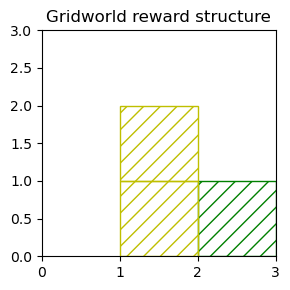

In [2]:
R = 100
P = -300
goals = [((2,0),R),((1,0),P),((1,1),P)]
gridMDP = Gridworld(3,3,0.1,0.9,goals=goals,obstacles=[]) 
gridMDP.init_distrib =  jnp.exp(jax.random.uniform(key,(gridMDP.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(gridMDP.n,))))
    
    
fig, ax = plt.subplots(1,figsize=(3,3))
gridplot(gridMDP,ax,goals=goals)
ax.set_title('Gridworld reward structure')
fig.tight_layout()
plt.show()

In [3]:
"""We define our parametrizations"""
policy_parametrization = lambda p : nn.softmax(p,axis=1)
reward_parametrization = lambda p : p # for now we work with the identity as the reward
"""As well as parameter vector vectors"""
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
w = jax.random.uniform(key,(gridMDP.n,gridMDP.m,))
"""And a regularizer"""
BETA = 2
shannonEntropy = lambda p : jnp.dot(jnp.log(p),p)
reg = lambda p : BETA*shannonEntropy(p)

### Training a reference policy

In [4]:
BETA = 20
STEPS = 30
LR = 0.5
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
pi_theta = nn.softmax(theta,axis=1)

shannonEntropy = lambda p : jnp.dot(jnp.log(p),p)
reg = lambda p : BETA*shannonEntropy(p)
parametrization = lambda p : nn.softmax(p,axis=1)
vanillaGradReg = vanillaGradOracle(gridMDP, None, key, parametrization, 1,1,reg)

def logger(theta):
    return {
        'theta': theta,
        'pi': parametrization(theta),
        'J': gridMDP.J(parametrization(theta))
    }
        
alg_reg = PolicyGradientMethod(gridMDP,key,vanillaGradReg,logger)
log_reg, theta_reg = alg_reg.train(STEPS,LR)
theta_expert = theta_reg
expert_reward = gridMDP.R
expert_reward.shape, w.shape

100%|██████████| 30/30 [00:00<00:00, 53.04it/s]


((9, 4), (9, 4))

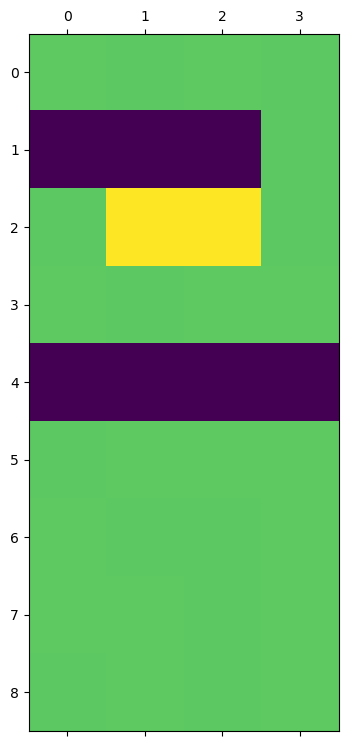

In [5]:
plt.matshow(expert_reward)

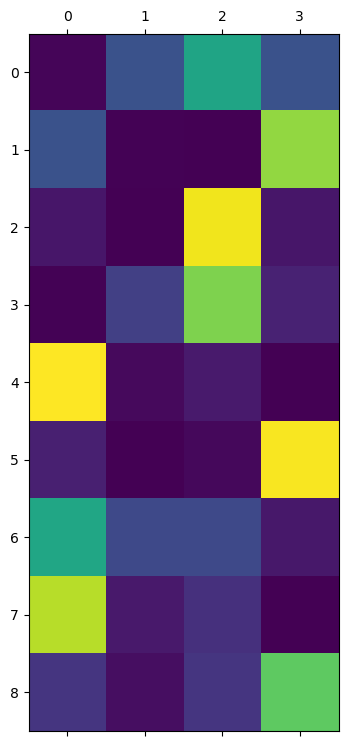

In [6]:
plt.matshow(policy_parametrization(theta_expert))

### Reward Gradient Oracle

In [7]:
def rewardGradOracle(p_param,r_param,p,p_xp,reg,mdp):
    return jax.jit(jax.grad(lambda p,w : mdp.J(p_param(p),reg,r_param(w)) - mdp.J(p_param(p_xp),reg,r_param(w)), 1))
    
rGrad = rewardGradOracle(policy_parametrization,reward_parametrization,theta,theta_expert,reg,gridMDP)
rGrad(theta,w)

DeviceArray([[ 0.01945056,  0.02184752,  0.00451983,  0.02896434],
             [ 0.01130912,  0.0148382 ,  0.02259923, -0.01681466],
             [ 0.01667563,  0.01749463, -0.25160116,  0.01116815],
             [ 0.02400635,  0.01608195, -0.00244075,  0.02002998],
             [ 0.01297873,  0.01440513,  0.03281034,  0.0198338 ],
             [-0.00729689,  0.02696091,  0.02955377, -0.27690168],
             [-0.01746706,  0.02375929,  0.02586431,  0.02860953],
             [-0.00462004,  0.02093205,  0.0259144 ,  0.02714202],
             [ 0.0157549 ,  0.03689471,  0.03373351, -0.02699062]],            dtype=float64)

### Natural Policy Gradient Oracle

In [8]:
def vanillaGradOracle(mdp,sampler,key,parametrization,B,H,reg=None):
    return jax.jit(jax.grad(lambda p : mdp.J(parametrization(p),reg)))

def naturalGradOracle(mdp,sampler,key,p_param,r_param,B,H,reg=None):
    def naturalGrad(theta,w):
        _shape = theta.shape
        g = jax.grad(lambda p,w : mdp.J(p_param(p),reg,reward=r_param(w)),0)(theta,w)    
        f_inv = jla.pinv(mdp.exactFIMOracle(theta,lambda p:nn.softmax(p,axis=1)))
        return jnp.reshape(f_inv@flatten(g),_shape)
    return jax.jit(naturalGrad)

pGrad = naturalGradOracle(gridMDP,None,None,policy_parametrization,reward_parametrization,1,1,reg)
pGrad(theta,w)

DeviceArray([[ 4.00497808, -2.91585641,  6.24797867, -7.33710034],
             [-2.08457968,  6.55284282, -0.65358099, -3.81468215],
             [-5.13167785,  7.39326285, -0.46004502, -1.80153997],
             [-0.49608326,  1.17878099, -0.45587254, -0.22682519],
             [-5.21774967,  8.77014165, -6.74871681,  3.19632483],
             [ 5.13802499, -0.93684949, -5.41738762,  1.21621212],
             [ 8.37699781, -3.31283774, -4.33884536, -0.72531471],
             [-5.45149582,  4.47109784, -1.13932421,  2.11972219],
             [ 4.66149299, -2.61684722, -4.88840945,  2.84376367]],            dtype=float64)

### Implementing `NPG-IRL`

In [9]:
def logger(theta,w,pG,rG):
    return {
        'theta': theta,
        'w': w,
        'pi': policy_parametrization(theta),
        'J': gridMDP.J(policy_parametrization(theta),reg,reward_parametrization(w)) - gridMDP.J(policy_parametrization(theta_expert),reg,reward_parametrization(w))
    }

In [10]:
nb_steps = 40
clip_thresh = 1e3
plr = 1e-3
rlr = 1e1

"""We define our parametrizations"""
policy_parametrization = lambda p : nn.softmax(p,axis=1)
reward_parametrization = lambda p : p # for now we work with the identity as the reward
"""As well as parameter vector vectors"""
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
w = l1proj(jax.random.uniform(key,(gridMDP.n,gridMDP.m,)))
"""And a regularizer"""
BETA = 2
shannonEntropy = lambda p : jnp.dot(jnp.log(p),p)
reg = lambda p : BETA*shannonEntropy(p)

mdp = gridMDP

log = [logger(theta,w,None,None)]
for _ in tqdm(range(nb_steps),disable=False):
    _pg = jnp.clip( pGrad(theta,w),
                    a_min=-clip_thresh,
                    a_max=clip_thresh)
    _pg = jax.numpy.nan_to_num(_pg, copy=False, nan=0.0)
    _rg = rGrad(theta,w)
    # TODO : Project the w values
    
    theta += plr * _pg
    w += rlr * _rg
    w = l2proj(w)
    log += [logger(theta,w,_pg,_rg)]
# log, theta


100%|██████████| 40/40 [00:00<00:00, 98.18it/s]


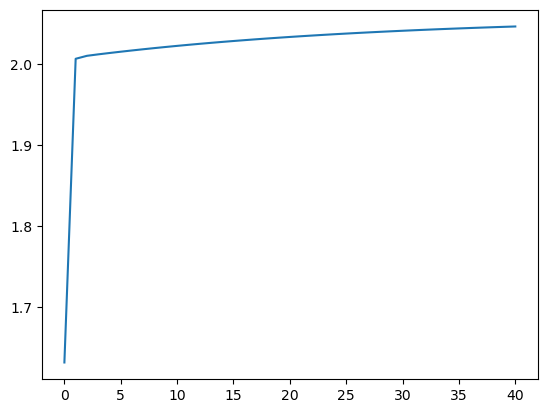

DeviceArray([[0.22695281, 0.26340885, 0.21735126, 0.29228708],
             [0.2606918 , 0.21236644, 0.25309264, 0.27384913],
             [0.28053339, 0.21143287, 0.24864334, 0.2593904 ],
             [0.25122737, 0.24575754, 0.25492324, 0.24809185],
             [0.2771191 , 0.20242503, 0.29207071, 0.22838515],
             [0.22072496, 0.25405215, 0.28944685, 0.23577604],
             [0.2039054 , 0.26837016, 0.27494128, 0.25278316],
             [0.28518179, 0.22464498, 0.25679372, 0.23337951],
             [0.22465226, 0.2652104 , 0.28131961, 0.22881772]],            dtype=float64)

In [14]:
Js = [e['J'] for e in log]
pis = [e['pi'] for e in log]
plt.plot(Js)
plt.show()
pis[-1]